In [51]:
import torch
import torch.nn as nn

# Critic

In [52]:
class Critic(nn.Module):

  def __init__(self, channels_img, features_d):
    super(Critic, self).__init__()
    self.crit = nn.Sequential(
        # input: N * channels_img* 64*64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        # N*feature_dim, 32*32
        self._block(features_d,features_d*2, 4 , 2 , 1), # N*feature_dim, 16*16
        self._block(features_d*2,features_d*4, 4 , 2 , 1), # N*feature_dim, 8*8
        self._block(features_d*4,features_d*8, 4 , 2 , 1), # N*feature_dim, 4*4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # N*feature_dim, 1*1
    )



  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2),
    )



  def forward(self,x):
    return self.crit(x)

# Generator

In [53]:
class Generator(nn.Module):

  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
            # input: N * z_dim * 1*1
            self._block(z_dim, features_g*16, 4, 1, 0), # N * f_g*16 * 4*4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8*8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16*16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32*32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # 64*64
            nn.Tanh(), # [-1,1]
    )

  def forward(self,x):
    return self.gen(x)


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

# Init model weights

In [54]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

# Test Model

In [55]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100

  x = torch.randn((N, in_channels, H, W))
  critic = Critic(in_channels, 8)
  initialize_weights(critic)
  assert critic(x).shape == (N, 1, 1, 1)

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")


test()

Success


### imports

In [56]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Hyperparameters

In [58]:
lr = 1e-4
batch_size = 64
img_size=64
channels_img = 1
z_dim = 100
num_epochs = 10
features_d = 64
features_g = 64

critic_iter = 5
lambda_gp = 10

# Transformations

In [59]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]
    )
])

# Load Data

In [60]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models, criterion and optimizer

In [61]:
gen = Generator(z_dim, channels_img,features_g).to(device)
critic = Critic(channels_img, features_d).to(device)

In [62]:
initialize_weights(gen)
initialize_weights(critic)

In [63]:
optim_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

In [64]:
fixed_noise = torch.randn(32,z_dim, 1, 1).to(device)

In [65]:
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [66]:
critic.train()

Critic(
  (crit): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [67]:
gen.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 1, 

# Gradient Penalty

In [68]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

# Training

Epoch [0/10] Batch 0/938                 Loss D: 46.0401, Loss G: 4.1050


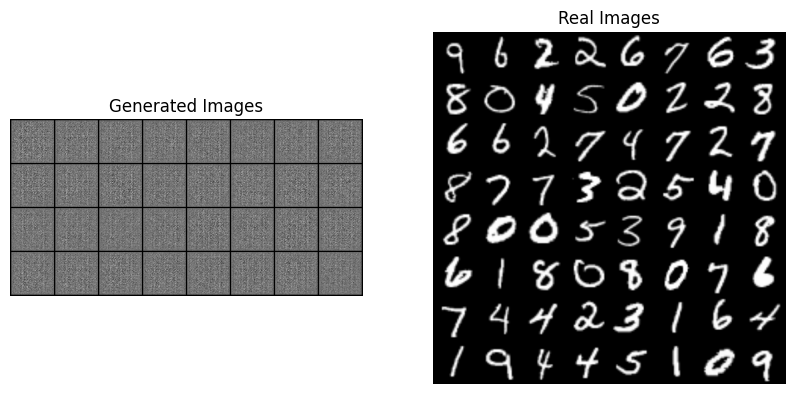

RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 0

In [69]:
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)

    for _ in range(critic_iter):
      noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      gp = gradient_penalty(critic, real, fake, device)
      loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp*gp )
      critic.zero_grad()
      loss_critic.backward(retain_graph=True) # to not clear graph after backpropagation immediately, helps us to utilize fake (noise) again
      optim_critic.step()

      # for p in critic.parameters():
      #   p.data.clamp_(-weight_clip, weight_clip)

    ## Train GENERATOR (min log(1-D(G(z))) <-> max log(D(G(z))) )
    output = critic(fake).reshape(-1)
    lossG = -torch.mean(output)
    gen.zero_grad()
    lossG.backward()
    optim_gen.step()


    # if batch_idx == 0:
    #         print(
    #             f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
    #                   Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
    #         )

    #         with torch.no_grad():
    #             fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
    #             data = real.reshape(-1, 1, 28, 28)
    #             img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
    #             img_grid_real = torchvision.utils.make_grid(data, normalize=True)

    #             writer_fake.add_image(
    #                 "Mnist Fake Images", img_grid_fake, global_step=step
    #             )
    #             writer_real.add_image(
    #                 "Mnist Real Images", img_grid_real, global_step=step
    #             )
    #             step += 1

    if batch_idx == 0:
       print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                Loss D: {loss_critic:.4f}, Loss G: {lossG:.4f}"
            )
       fig, axes = plt.subplots(1, 2, figsize=(10, 5))

       with torch.no_grad():
          fake = gen(fixed_noise).reshape(-1, 1, 64, 64).cpu()  # Move to CPU
          data = real.reshape(-1, 1, 64, 64).cpu()  # Move to CPU

          # Visualize fake images
          img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
          axes[0].imshow(img_grid_fake.permute(1, 2, 0), cmap='gray')  # Adjust permute for channel order
          axes[0].set_title('Generated Images')
          axes[0].axis('off')

          # Visualize real images
          img_grid_real = torchvision.utils.make_grid(data[:32], normalize=True)
          axes[1].imshow(img_grid_real.permute(1, 2, 0), cmap='gray')  # Adjust permute for channel order
          axes[1].set_title('Real Images')
          axes[1].axis('off')

          plt.show()